In [1]:
import numpy as np
import pandas as pd
import pickle
import plotnine as p9
from vbayesfa.lpa_outcome_analysis import fit_y_normal, fit_y_bernoulli
from vbayesfa.lpa import lpa_model
from vbayesfa.fit_lpa import fit_lpa

%matplotlib inline
data_set = '0 missing'#'<= 2 missing'#
plot_path = '/Users/sampaskewitz/Dropbox/SamP-Arielle/ABCD Fingerprint/figures for paper/'

/Users/sampaskewitz/miniconda3/envs/abcd/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# load fitted LPA model

path = '/Users/sampaskewitz/Documents/ABCD model fitting/DPM-LPA fitting/'
if data_set == '<= 2 missing':
    file = open(path + '10-06-2023 (best infinite LPA model, full data set).pkl', "rb")
    #file = open(path + '10-04-2023 (best infinite LPA model, stronger prior on alpha = 1).pkl', "rb")
elif data_set == '0 missing':
    file = open(path + '10-10-2023 (best infinite LPA model, no missing data).pkl', "rb")

model = pickle.load(file)
model._update_hard_assignment()
file.close()

# data

path = '/Users/sampaskewitz/Documents/ABCD data processing/complete data sets (z-scored etc)/'

x = pd.read_csv(path + 'task behavioral data (2-year z-scored full data).csv',
                index_col = 0).loc[model.index]
y_cont = pd.read_csv(path + 'outcome data (2-year z-scored full data).csv',
                     index_col = 0).loc[model.index]
y_cont.drop(['extern_youth', 'intern_youth', 'atten_youth', 'with_dep', 'anx_dep', 'somatic', 'alc_pos_expect', 'alc_neg_expect'],
             axis = 1,
             inplace = True)
y_binary = pd.read_csv(path + 'outcome data (2-year binary vars full data).csv',
                       index_col = 0).loc[model.index, ['any_substance_use', 'conduct_disorder']]
y_cont_3year = pd.read_csv(path + 'outcome data (3-year z-scored full data).csv',index_col = 0).loc[model.index]
y_cont_3year.drop(['extern_youth', 'intern_youth', 'atten_youth', 'neg_urg', 'pos_urg', 'with_dep', 'anx_dep', 'somatic', 'alc_pos_expect', 'alc_neg_expect'],
                  axis = 1,
                  inplace = True)
y_binary_3year = pd.read_csv(path + 'outcome data (3-year binary vars full data).csv',
                             index_col = 0).loc[model.index, ['any_substance_use', 'conduct_disorder']]
info = pd.read_csv('/Users/sampaskewitz/Documents/ABCD data processing/processed data (release 5.0)/ABCD 2-year demographic info etc.csv',
                   index_col = 0).loc[model.index]


# nice names for data variables
nice_x_names = {'little_man': 'spatial processing',
                'ravlt': 'auditory memory',
                'dice': 'decision-making',
                'reading': 'reading decoding',
                'picture': 'visual-spatial memory',
                'pattern': 'processing speed',
                'flanker': 'cognitive/attentional control',
                'picvocab': 'vocabulary',
                'neg_ssrt': 'response inhibition',
                'recog_dprime': 'recognition memory',
                'two_back': 'working memory'}

nice_y_names = {'neg_urg': 'negative urgency',
                'pos_urg': 'positive urgency',
                'intern': 'internalizing',
                'agrs': 'aggression',
                'rbreak': 'rule-breaking',
                'extern': 'externalizing'}

# rename columns
x = x.rename(columns = nice_x_names)
y_cont = y_cont.rename(columns = nice_y_names)
y_cont.columns = pd.Categorical(y_cont.columns, 
                                categories = ['externalizing', 'rule-breaking', 'aggression', 'positive urgency', 'negative urgency', 'internalizing'],
                                ordered = True)
y_cont_3year = y_cont_3year.rename(columns = nice_y_names)
y_cont_3year.columns = pd.Categorical(y_cont_3year.columns, 
                                      categories = ['externalizing', 'rule-breaking', 'aggression', 'internalizing'],
                                      ordered = True)
model.x_names = pd.Series(nice_x_names)[model.x_names].values
model.x_names = pd.Categorical(model.x_names, 
                               categories = ['cognitive/attentional control', 'processing speed', 'response inhibition', 'working memory',
                                             'visual-spatial memory', 'auditory memory', 'recognition memory',
                                             'vocabulary', 'reading decoding', 'spatial processing', 'decision-making'], 
                               ordered = True)

In [5]:
# compare people with and without missing neurocognitive data

info_missing = pd.read_csv('/Users/sampaskewitz/Documents/ABCD data processing/processed data (release 5.0)/ABCD 2-year demographic info etc.csv',
                           index_col = 0).loc[lambda df: ~df.index.isin(model.index)]
info_df = pd.DataFrame(columns = ['n', 'age', '% Female', '% Male', '% Asian', '% Black', '% Hispanic', '% Other', '% White'], index = ['complete', 'missing'])
info_df.loc['complete', 'n'] = info.shape[0]
info_df.loc['missing', 'n'] = info_missing.shape[0]
info_df.loc['complete', 'age'] = info['age'].mean().round(1)
info_df.loc['missing', 'age'] = info_missing['age'].mean().round(1)
info_df.loc['complete', ['% Female', '% Male']] = 100*(info['sex'].value_counts()[['Female', 'Male']]/info.shape[0]).round(3).values
info_df.loc['missing', ['% Female', '% Male']] = 100*(info_missing['sex'].value_counts()[['Female', 'Male']]/info_missing.shape[0]).round(3).values
info_df.loc['complete', ['% White', '% Hispanic', '% Black', '% Other', '% Asian']] = 100*(info['race_ethnicity'].value_counts()/info.shape[0]).round(3).values
info_df.loc['missing', ['% White', '% Hispanic', '% Black', '% Other', '% Asian']] = 100*(info_missing['race_ethnicity'].value_counts()/info_missing.shape[0]).round(3).values
info_df


,n,age,% Female,% Male,% Asian,% Black,% Hispanic,% Other,% White
complete,5232,119.1,47.9,52.1,1.9,11.0,18.9,10.2,57.9
missing,6636,118.9,47.8,52.1,2.3,18.2,21.4,10.7,47.4


In [9]:
# export a list of GUIDs (subject IDs) as a .csv file
info_missing.index.to_frame().to_csv('GUIDs.csv', index = False, header = False)

In [4]:
100*(info_missing['sex'].value_counts()/info_missing.shape[0]).round(4).values

array([5.214e+01, 4.781e+01, 5.000e-02])

In [5]:
y_cont_missing = pd.read_csv(path + 'outcome data (2-year z-scored full data).csv',
                             index_col = 0).loc[lambda df: ~df.index.isin(model.index)]
y_cont_missing.drop(['extern_youth', 'intern_youth', 'atten_youth', 'with_dep', 'anx_dep', 'somatic', 'alc_pos_expect', 'alc_neg_expect'],
                    axis = 1,
                    inplace = True)
y_cont_missing = y_cont_missing.rename(columns = nice_y_names)
y_cont_missing

,externalizing,rule-breaking,aggression,internalizing,positive urgency,negative urgency
NDAR_INV003RTV85,NaN,NaN,NaN,NaN,-0.154171,-1.189130
NDAR_INV005V6D2C,-1.069500,-0.506369,-0.477988,-1.408400,0.594181,0.088474
NDAR_INV007W6H7B,NaN,NaN,NaN,NaN,NaN,NaN
NDAR_INV00BD7VDC,NaN,NaN,NaN,NaN,0.220005,-0.337394
NDAR_INV00HEV6HB,1.583835,1.893051,1.538416,0.402343,-1.276699,1.791947
...,...,...,...,...,...,...
NDAR_INVZZJ3A7BK,0.665373,0.453399,-0.276348,1.450668,3.213413,2.217815
NDAR_INVZZL0VA2F,NaN,NaN,NaN,NaN,NaN,NaN
NDAR_INVZZNX6W2P,0.665373,-0.026485,-0.074708,-0.741284,0.220005,0.940211
NDAR_INVZZZNB0XC,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
y_cont_missing['externalizing'].isna().value_counts()

externalizing
True     3532
False    3104
Name: count, dtype: int64

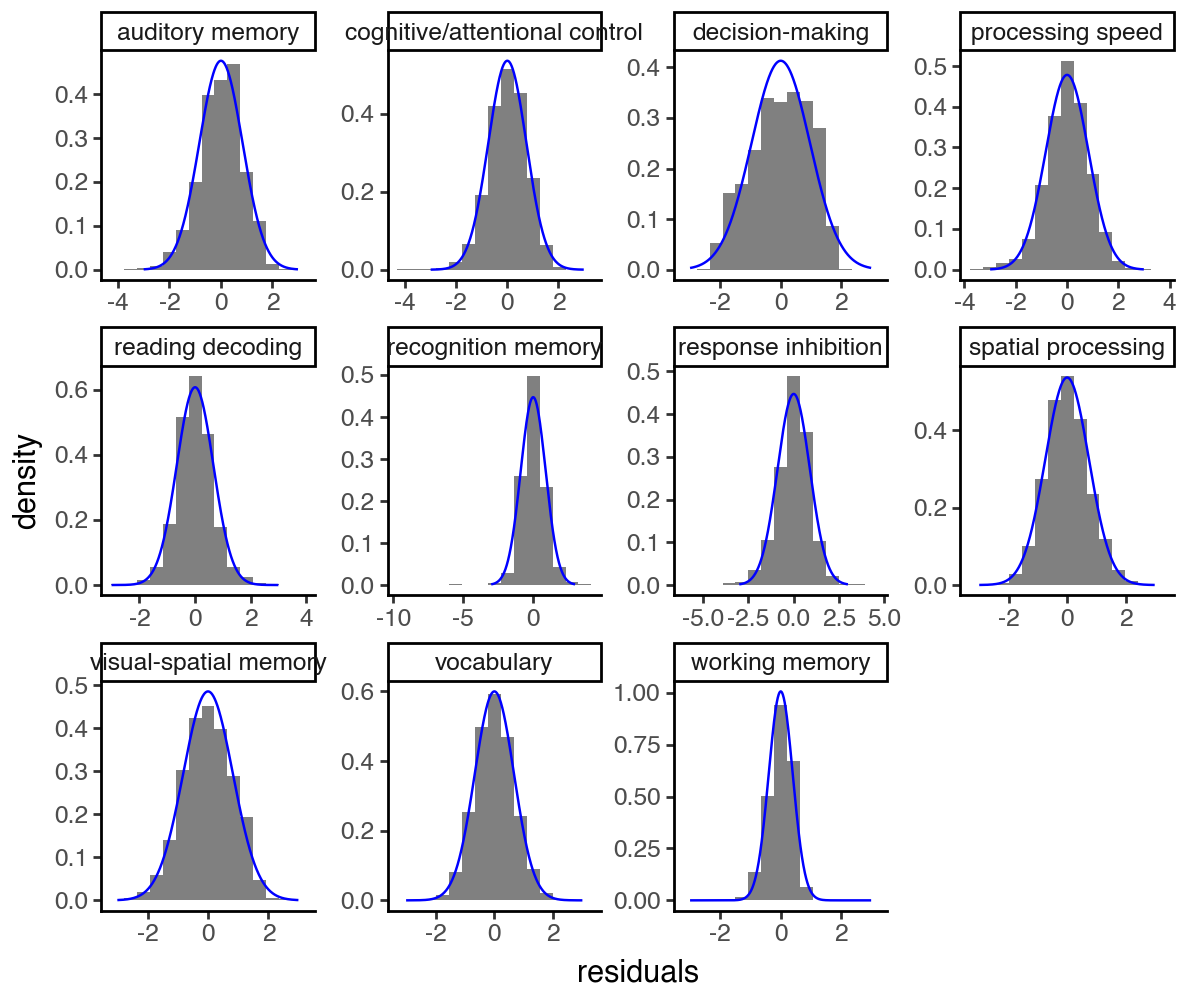

In [7]:
# residual plots
model.plot_residuals(bins = 15)

In [8]:
# model residual correlations (to check the local independence assumption)
model.residual_correlations()

,working memory,recognition memory,response inhibition,vocabulary,cognitive/attentional control,processing speed,visual-spatial memory,reading decoding,decision-making,auditory memory,spatial processing
working memory,1.00,0.04,-0.03,-0.07,-0.07,-0.06,-0.05,-0.09,-0.02,-0.08,-0.04
recognition memory,0.04,1.00,0.05,-0.07,-0.10,-0.03,0.02,-0.02,-0.01,-0.01,-0.05
response inhibition,-0.03,0.05,1.00,-0.05,-0.04,0.05,0.01,0.02,0.05,-0.00,-0.00
vocabulary,-0.07,-0.07,-0.05,1.00,-0.03,-0.08,-0.06,0.11,0.04,-0.07,-0.09
cognitive/attentional control,-0.07,-0.10,-0.04,-0.03,1.00,0.17,-0.09,-0.04,-0.04,-0.07,0.01
processing speed,-0.06,-0.03,0.05,-0.08,0.17,1.00,0.00,-0.08,-0.02,-0.05,0.02
visual-spatial memory,-0.05,0.02,0.01,-0.06,-0.09,0.00,1.00,-0.11,0.01,0.19,-0.03
reading decoding,-0.09,-0.02,0.02,0.11,-0.04,-0.08,-0.11,1.00,-0.06,-0.06,-0.01
decision-making,-0.02,-0.01,0.05,0.04,-0.04,-0.02,0.01,-0.06,1.00,-0.07,-0.01
auditory memory,-0.08,-0.01,-0.00,-0.07,-0.07,-0.05,0.19,-0.06,-0.07,1.00,-0.02


In [9]:
# demographic data
print(np.round(100*info['sex'].value_counts()/model.n, 1))
print()
print(np.round(100*info['race_ethnicity'].value_counts()/model.n, 1))

sex
Male      52.1
Female    47.9
Name: count, dtype: float64

race_ethnicity
White       57.9
Hispanic    18.9
Black       11.0
Other       10.2
Asian        1.9
Name: count, dtype: float64


In [10]:
def cor_plot(data, figure_size = [5, 3], font_size = 8, title = None):
    '''
    Convenience function for drawing a correlation matrix heatmap.
    '''
    cor_matrix = np.round(data.corr(), 2)
    cor_matrix = cor_matrix.stack().reset_index()
    cor_matrix.columns = ['variable 1', 'variable 2', 'r']
    if data.columns.dtype.name == 'category':
        cor_matrix['variable 1'] = pd.Categorical(cor_matrix['variable 1'], categories = data.columns.categories.values, ordered = True) # don't change the order of variables
        cor_matrix['variable 2'] = pd.Categorical(cor_matrix['variable 2'], categories = data.columns.categories.values, ordered = True) # don't change the order of variables
    
    plot = (p9.ggplot(cor_matrix, p9.aes('variable 1', 'variable 2', fill = 'r'))
            + p9.geom_tile(p9.aes(width=1.2, height=1.2))
            + p9.geom_text(p9.aes(label='r'), size=font_size-2)
            + p9.theme_classic(base_size = font_size)
            + p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1),
                       figure_size = figure_size,
                       legend_position = 'top')
            + p9.scale_fill_gradient2(low='#FAD0C3', mid='white', high='#8ed1fc', midpoint=0, limits=[-1,1])
            + p9.xlab('') + p9.ylab('')
)
    if not title is None:
        plot += p9.ggtitle(title)
    return plot

/Users/sampaskewitz/miniconda3/envs/abcd/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5.4 x 5.4 in image.
/Users/sampaskewitz/miniconda3/envs/abcd/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /Users/sampaskewitz/Dropbox/SamP-Arielle/ABCD Fingerprint/figures for paper/correlation between all variables


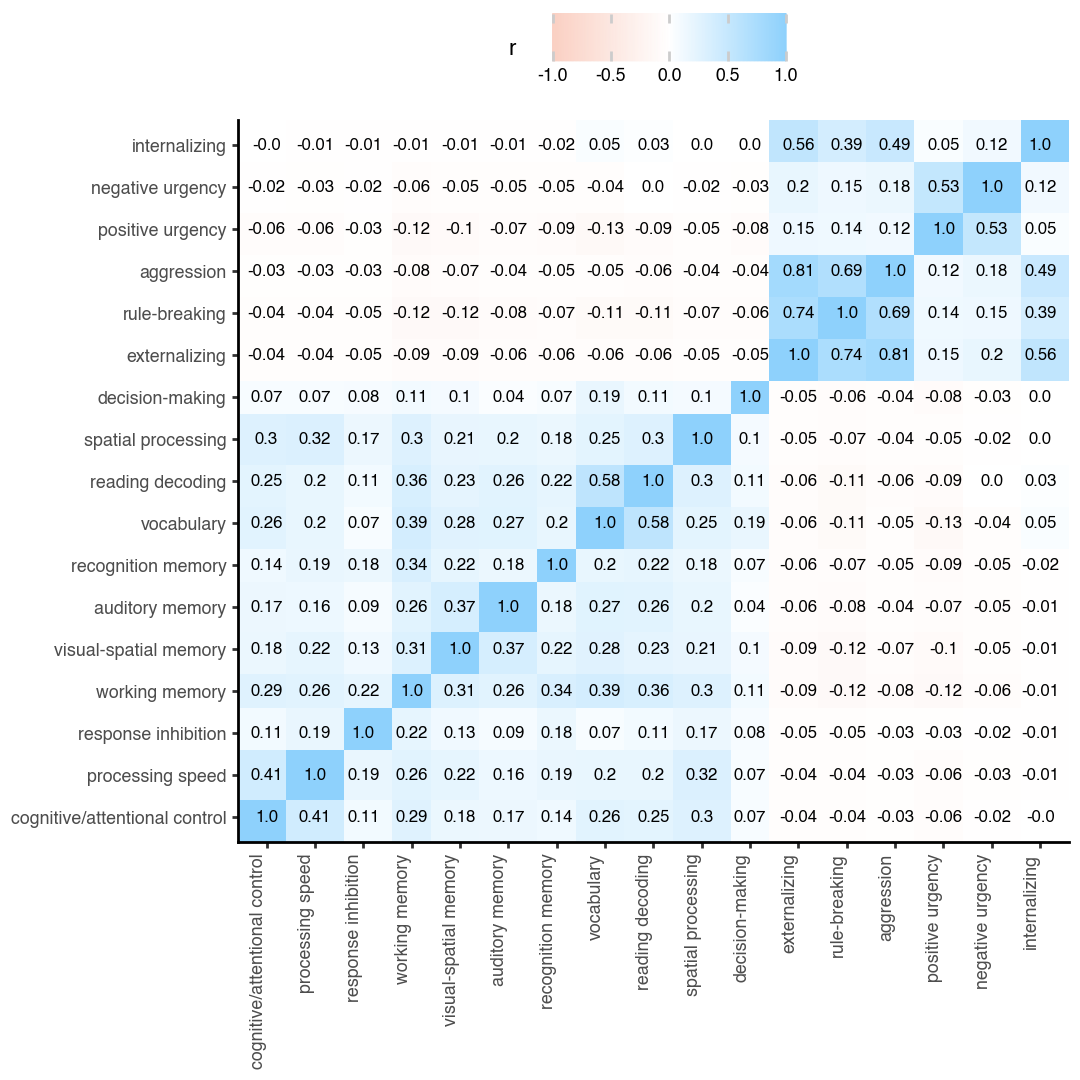

In [11]:
combo_data = pd.concat([x, y_cont], axis = 1)
combo_data.columns = pd.Categorical(combo_data.columns, 
                                    categories = ['cognitive/attentional control', 'processing speed', 'response inhibition', 'working memory',
                                         'visual-spatial memory', 'auditory memory', 'recognition memory',
                                         'vocabulary', 'reading decoding', 'spatial processing', 'decision-making',
                                         'externalizing', 'rule-breaking', 'aggression', 'positive urgency', 'negative urgency', 'internalizing'],
                                    ordered = True)

xy_cor_plot = cor_plot(combo_data, 
                       figure_size = [5.4, 5.4], 
                       font_size = 8)
xy_cor_plot.save(plot_path + 'correlation between all variables', dpi = 300)
xy_cor_plot

In [12]:
combo_data.corr()

,working memory,recognition memory,response inhibition,vocabulary,cognitive/attentional control,processing speed,visual-spatial memory,reading decoding,decision-making,auditory memory,spatial processing,externalizing,rule-breaking,aggression,internalizing,positive urgency,negative urgency
working memory,1.000000,0.335088,0.218305,0.389273,0.288844,0.262651,0.307247,0.356581,0.113302,0.255720,0.304547,-0.089186,-0.117111,-0.079587,-0.013362,-0.122887,-0.062824
recognition memory,0.335088,1.000000,0.184333,0.203767,0.142559,0.187706,0.221214,0.222148,0.072032,0.181696,0.183853,-0.061861,-0.071442,-0.054153,-0.022603,-0.094181,-0.046489
response inhibition,0.218305,0.184333,1.000000,0.072136,0.106467,0.187447,0.127368,0.111002,0.077807,0.088905,0.168036,-0.045646,-0.045903,-0.033632,-0.007938,-0.033085,-0.024465
vocabulary,0.389273,0.203767,0.072136,1.000000,0.258127,0.196743,0.279489,0.575901,0.185066,0.274096,0.249923,-0.059671,-0.110754,-0.054234,0.048794,-0.129697,-0.040708
cognitive/attentional control,0.288844,0.142559,0.106467,0.258127,1.000000,0.409136,0.181567,0.251565,0.074438,0.166611,0.297090,-0.040438,-0.035857,-0.031491,-0.004456,-0.057172,-0.015936
processing speed,0.262651,0.187706,0.187447,0.196743,0.409136,1.000000,0.219104,0.196062,0.070572,0.155404,0.316703,-0.041928,-0.035974,-0.030711,-0.013555,-0.063514,-0.030231
visual-spatial memory,0.307247,0.221214,0.127368,0.279489,0.181567,0.219104,1.000000,0.231343,0.101459,0.373653,0.211486,-0.092969,-0.119721,-0.073021,-0.009688,-0.099762,-0.054599
reading decoding,0.356581,0.222148,0.111002,0.575901,0.251565,0.196062,0.231343,1.000000,0.114915,0.264924,0.303690,-0.064322,-0.109254,-0.060542,0.031898,-0.093943,0.004750
decision-making,0.113302,0.072032,0.077807,0.185066,0.074438,0.070572,0.101459,0.114915,1.000000,0.039176,0.096542,-0.052693,-0.056217,-0.044975,0.004171,-0.079788,-0.033108
auditory memory,0.255720,0.181696,0.088905,0.274096,0.166611,0.155404,0.373653,0.264924,0.039176,1.000000,0.204481,-0.061131,-0.079718,-0.044707,-0.008479,-0.073843,-0.051227


In [13]:
print('sample sizes for continuous outcome variables (y)\n')
print(('\n two year followup\n'))
print((1 - y_cont.isna()).sum(axis = 0))
print(('\n three year followup\n'))
print((1 - y_cont_3year.isna()).sum(axis = 0))

sample sizes for continuous outcome variables (y)


 two year followup

externalizing       4977
rule-breaking       4977
aggression          4977
internalizing       4977
positive urgency    5230
negative urgency    5230
dtype: int64

 three year followup

externalizing    4742
rule-breaking    4742
aggression       4742
internalizing    4742
dtype: int64


In [14]:
model.print_summary(start_profile_labels_from1 = True)

n = 5232

proportional entropy reduction: 0.84
(= 1 - entropy of z/max entropy of z)

number of non-empty profiles: 9

pi (profile probabilties): 
  profile 1  profile 2  profile 3  profile 4  profile 5  profile 6  profile 7  \
       0.58       0.12        0.1       0.09       0.05       0.03       0.02   

  profile 8  profile 9  
       0.01       0.01  

number in each profile: 
  profile 1  profile 2  profile 3  profile 4  profile 5  profile 6  profile 7  \
       3018        616        531        457        243        162         88   

  profile 8  profile 9  
         74         43  

mu: (means)
                               profile 1  profile 2  profile 3  profile 4  \
working memory                      0.30       0.70      -0.45       0.66   
recognition memory                  0.04       0.69      -0.35       0.50   
response inhibition                -0.00       0.43       0.04       0.19   
vocabulary                          0.06       0.50      -1.07       1.43   
cog

In [15]:
model.z_hat + 1

array([1, 8, 2, ..., 5, 1, 2])

In [16]:
# For export to R for analysis with the Bayes factor package there (as an alternative to my home-grown fractional Bayes factors).

export = False
if export:
    def compute_partition_df(z, index):
        n = z.shape[1] # number of observations
        n_t_overall = z.shape[0] # number of groups
        partition_list = list(partition(list(range(n_t_overall)))) # list of all partitions
        partition_list.pop(0) # remove the initial partition, which has everyone in the same group (H0)
        n_partitions = len(partition_list)
        df = pd.DataFrame(0.0, columns = ['partition_' + str(p + 1) for p in range(n_partitions)], index = index)
        partition_def_str = []
        z_flat = z.argmax(axis = 0)
        
        for p in range(n_partitions):
            prt = partition_list[p] # current partition
            partition_size = len(prt) # number of groups in the partition
            for t in range(partition_size):
                df.loc[np.isin(z_flat, prt[t]), 'partition_' + str(p + 1)] = t
            partition_def_str += [str(prt)]
        
        return df, pd.Series(partition_def_str, index = ['partition_' + str(p + 1) for p in range(n_partitions)])
    
    (partition_df, partition_def_str) = compute_partition_df(model.z_hat_1hot, model.index)

    partition_def_str.to_csv('partition_definitions.csv')

    hard_2year = pd.concat([y_cont, partition_df], axis = 1)
    hard_2year.to_csv('for_hard_analysis_2year (' + data_set + ').csv')

    hard_3year = pd.concat([y_cont_3year, partition_df], axis = 1)
    hard_3year.to_csv('for_hard_analysis_3year (' + data_set + ').csv')

In [17]:
hard_2year = y_cont.copy()
hard_2year['z_hat'] = model.z_hat + 1
hard_2year.to_csv('for_hard_analysis_2year (' + data_set + ').csv')

hard_3year = y_cont_3year.copy()
hard_3year['z_hat'] = model.z_hat + 1
hard_3year.to_csv('for_hard_analysis_3year (' + data_set + ').csv')

In [18]:
hard_2year

,externalizing,rule-breaking,aggression,internalizing,positive urgency,negative urgency,z_hat
NDAR_INV00CY2MDM,2.502298,1.893051,4.563022,0.974156,0.220005,0.088474,1
NDAR_INV00U4FTRU,NaN,NaN,NaN,NaN,1.716709,1.366079,8
NDAR_INV00X2TBWJ,-0.048986,-0.266427,-0.477988,0.211738,-0.154171,0.088474,2
NDAR_INV010ZM3H9,0.665373,-0.506369,0.530214,0.592947,-1.276699,-0.763262,5
NDAR_INV014RTM1V,-1.171551,-0.506369,-0.477988,-0.645982,-0.154171,-1.189130,1
...,...,...,...,...,...,...,...
NDAR_INVZZ6ZJ2KY,0.971527,-0.266427,0.731854,-0.455378,2.465061,0.514343,1
NDAR_INVZZ81LEEV,-1.171551,-0.506369,-0.477988,-0.264773,-0.528347,0.514343,1
NDAR_INVZZLZCKAY,0.971527,0.693341,0.328573,1.831877,0.594181,1.366079,5
NDAR_INVZZPKBDAC,-1.069500,-0.506369,-0.477988,-0.836587,-1.276699,-1.189130,1


In [19]:
#model.print_univariate_entropy_stats()

/Users/sampaskewitz/miniconda3/envs/abcd/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 8 in image.
/Users/sampaskewitz/miniconda3/envs/abcd/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /Users/sampaskewitz/Dropbox/SamP-Arielle/ABCD Fingerprint/figures for paper/profile_means


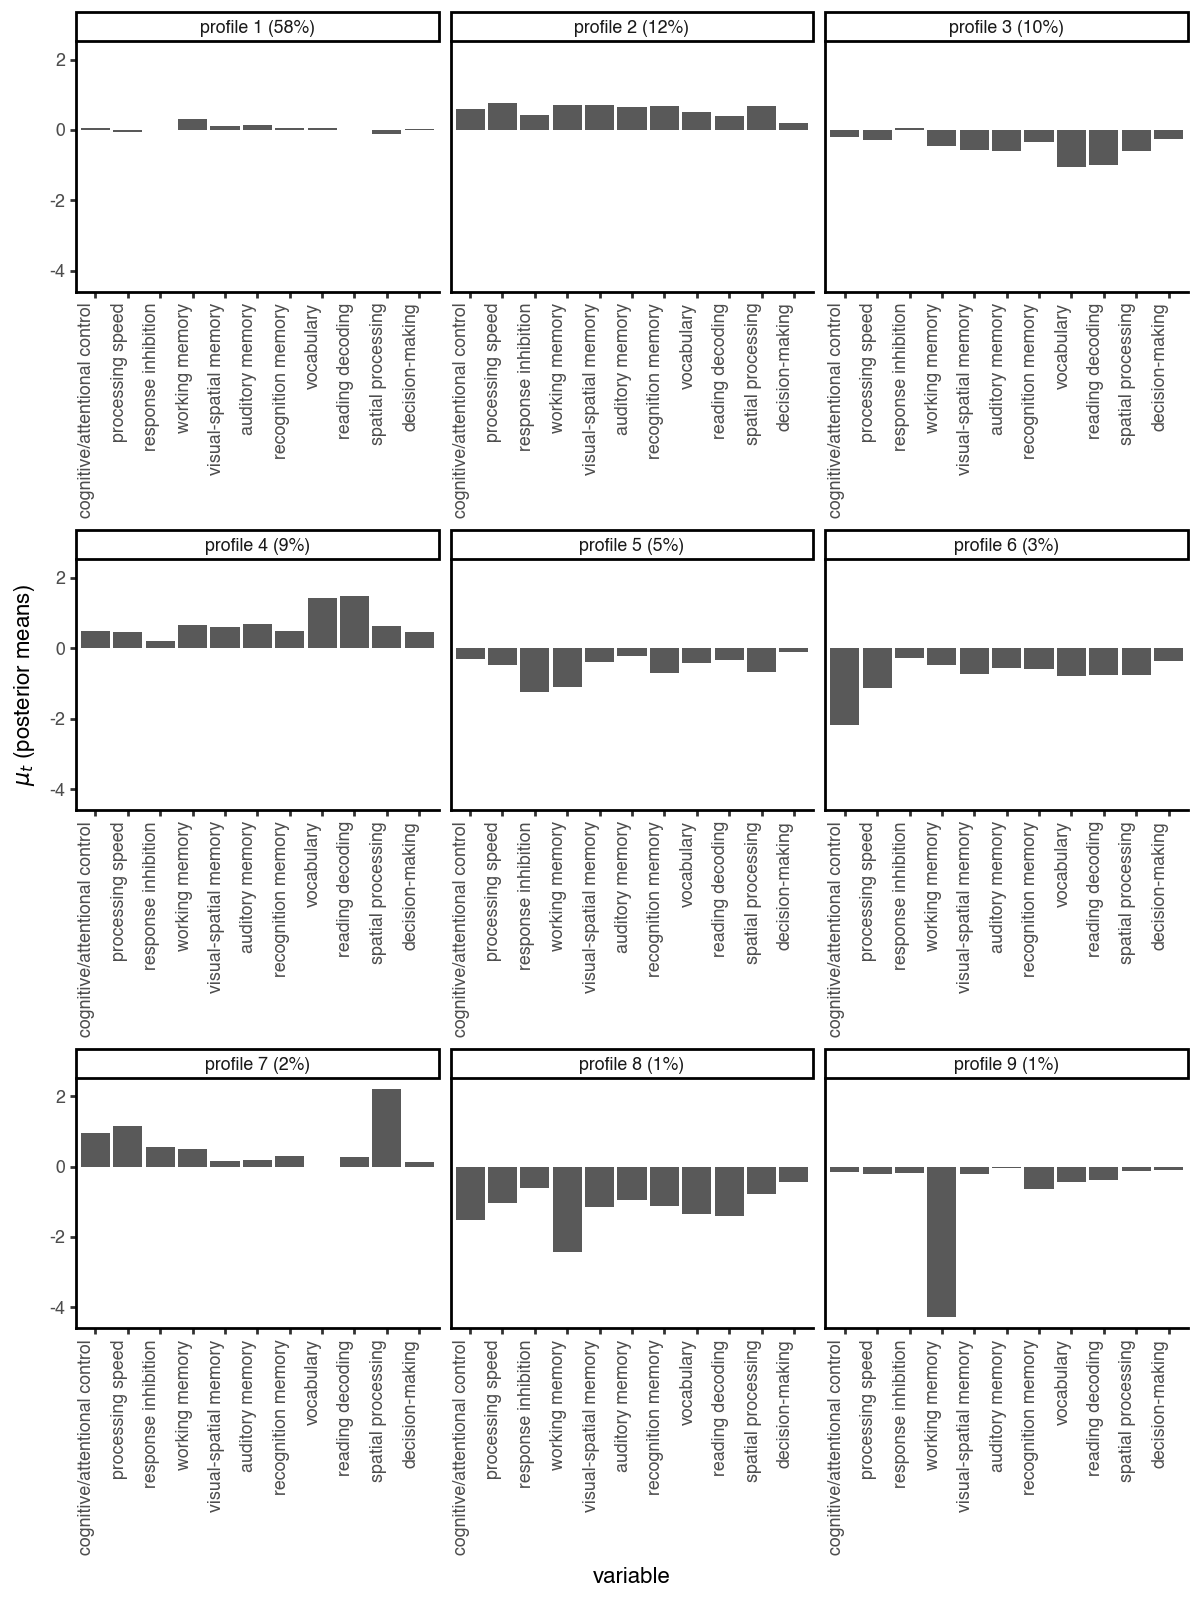

In [5]:
profile_plot = model.plot_profile_means(figure_size = [6, 8],
                                        ncol = 3,
                                        font_size = 8,
                                        start_profile_labels_from1 = True,
                                        facet_var = 'profile')

profile_plot += p9.ylab('$\\mu_t$ (posterior means)')
profile_plot.save(plot_path + 'profile_means', dpi = 300)
profile_plot

/Users/sampaskewitz/miniconda3/envs/abcd/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 14.3 x 9 in image.
/Users/sampaskewitz/miniconda3/envs/abcd/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /Users/sampaskewitz/Dropbox/SamP-Arielle/ABCD Fingerprint/figures for paper/profile_means (poster version)


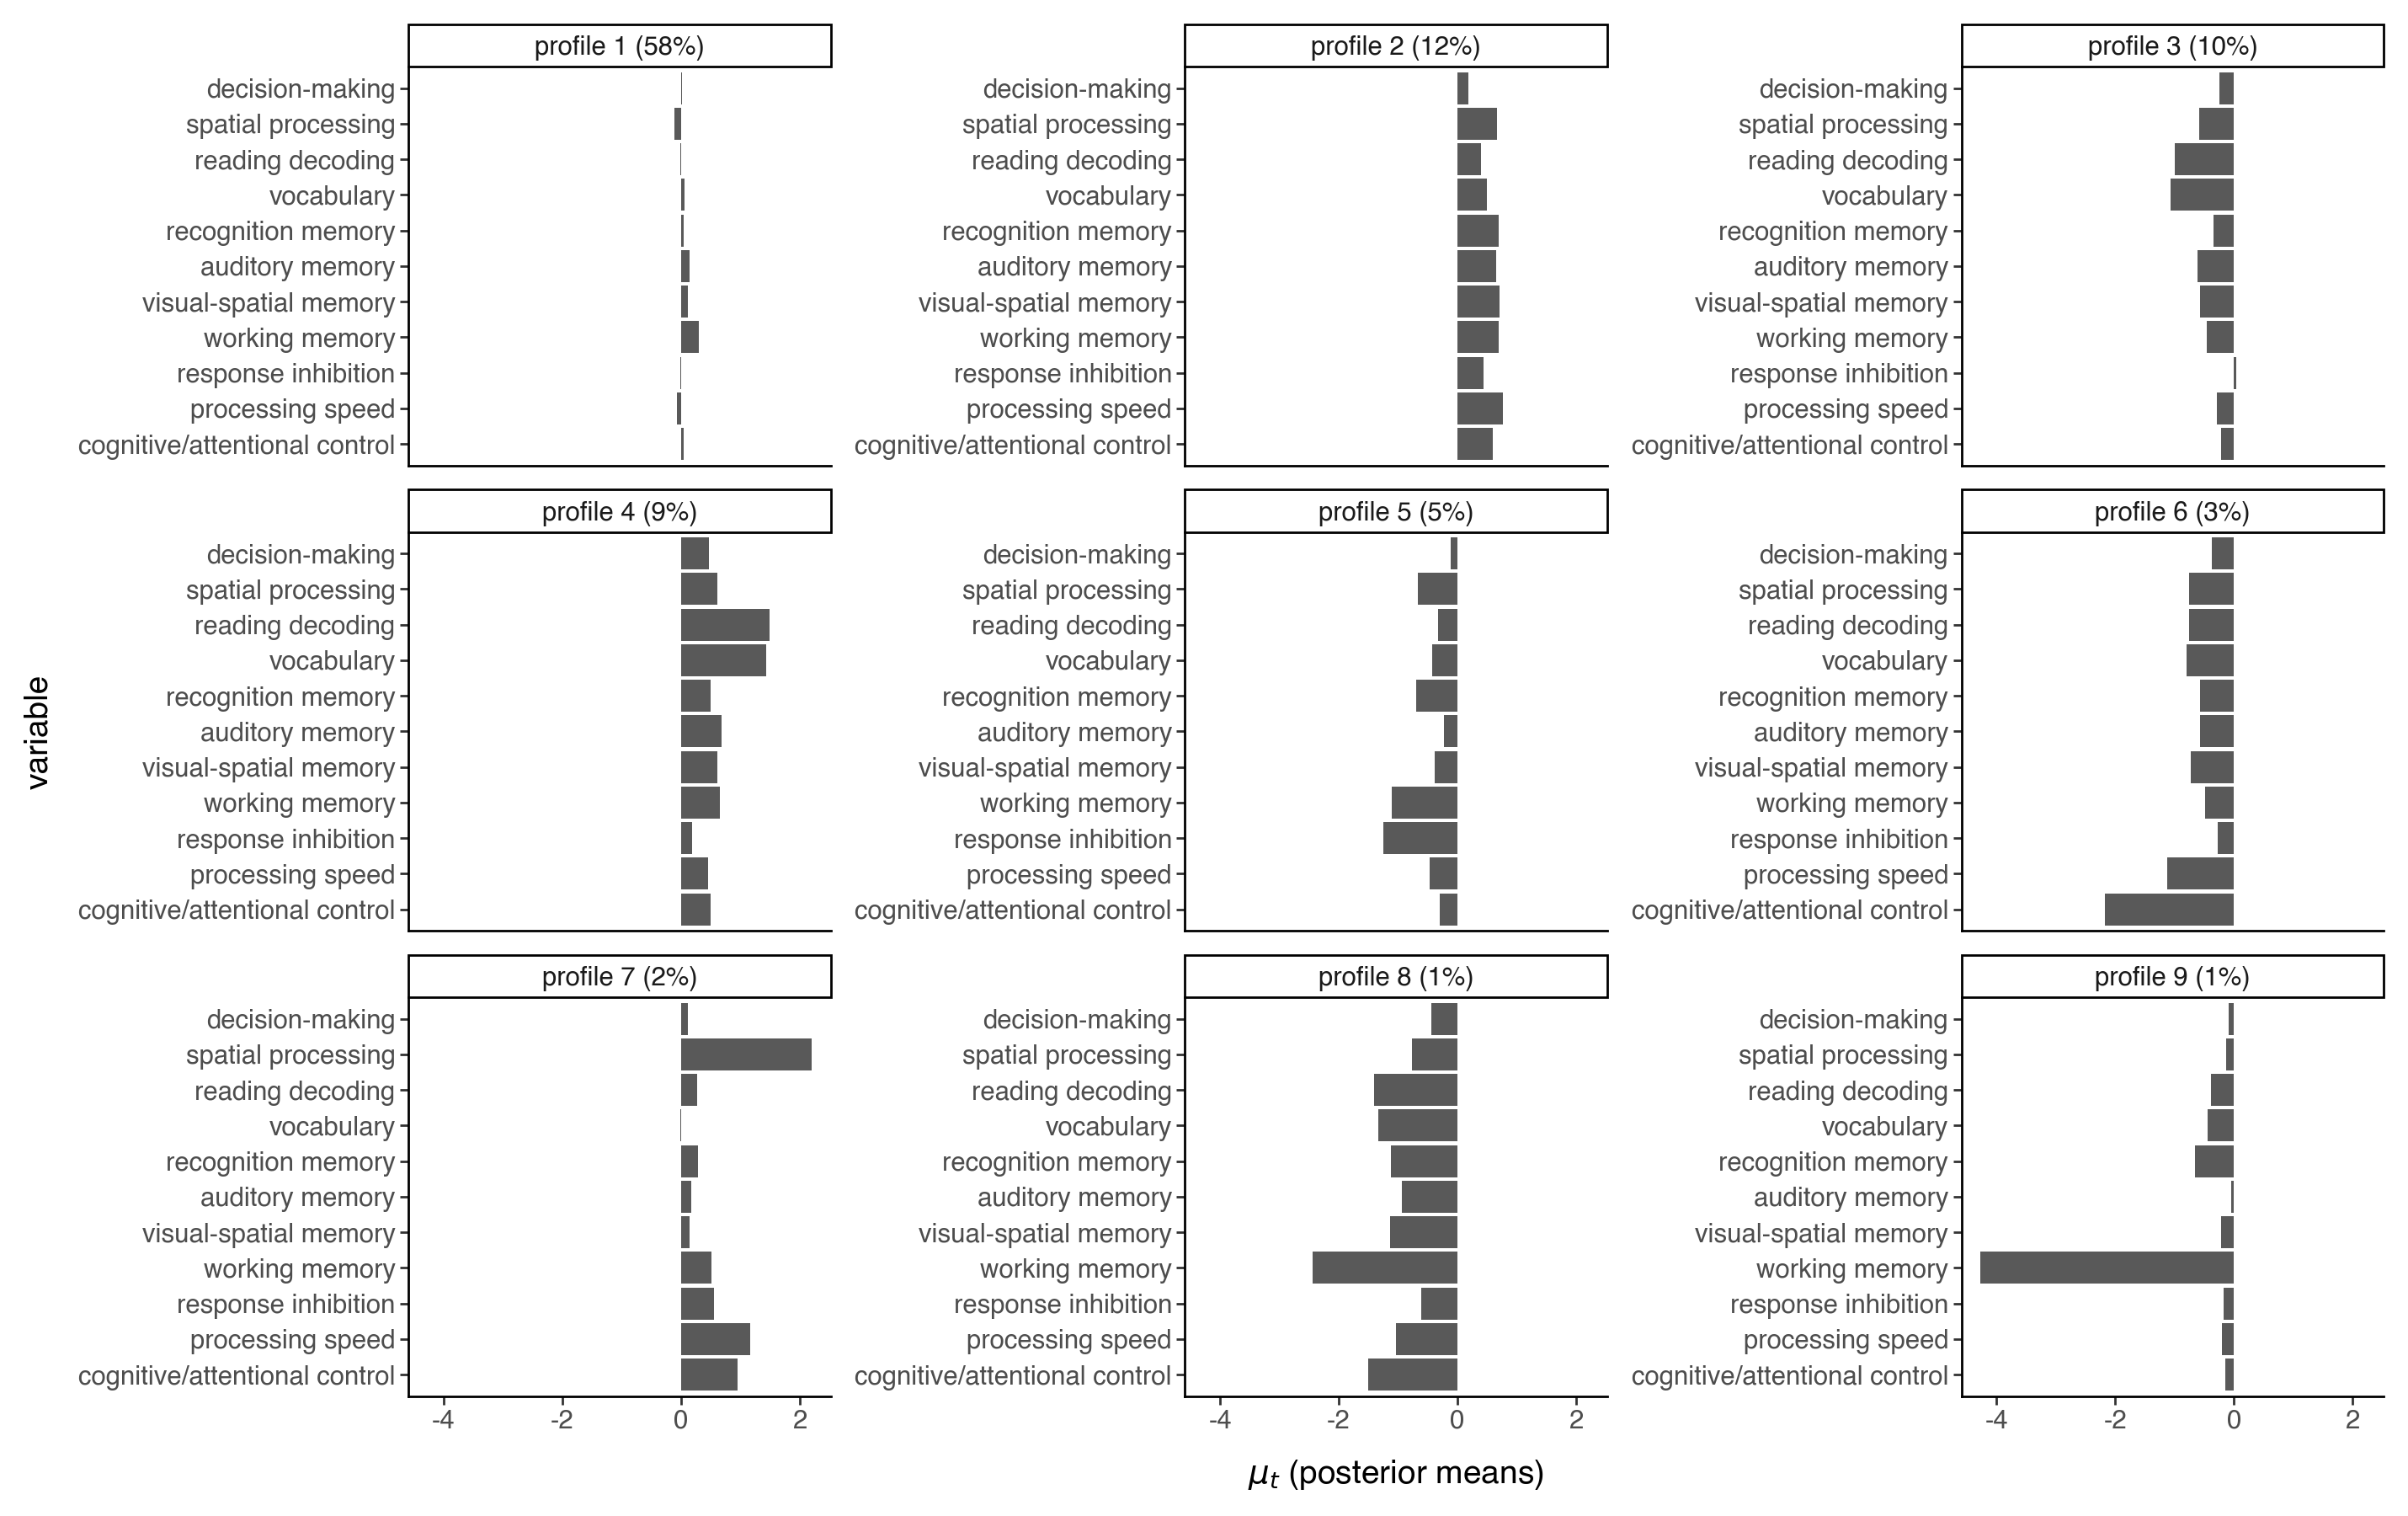

In [21]:
# each column of the poster is about 14.4 inches wide
profile_plot_poster = model.plot_profile_means(figure_size = [14.3, 9],
                                                ncol = 3,
                                                font_size = 14,
                                                start_profile_labels_from1 = True,
                                                facet_var = 'profile (flipped)')

profile_plot_poster += p9.ylab('$\\mu_t$ (posterior means)')
profile_plot_poster.save(plot_path + 'profile_means (poster version)', dpi = 300, limitsize=False)
profile_plot_poster.show()

[[1.   0.07 0.01 0.   0.   0.   0.   0.   0.  ]
 [0.07 1.   0.   0.12 0.   0.   0.06 0.   0.  ]
 [0.01 0.   1.   0.   0.05 0.02 0.   0.   0.  ]
 [0.   0.12 0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.05 0.   1.   0.01 0.   0.   0.  ]
 [0.   0.   0.02 0.   0.01 1.   0.   0.   0.  ]
 [0.   0.06 0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]
max similarity: 0.11851776
mean similarity: 0.00928003
min distance: 2.06528082
mean distance: 5.98958423


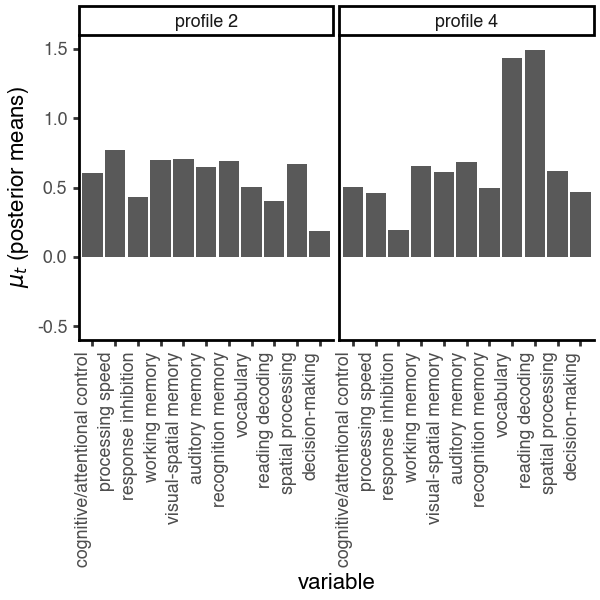

In [22]:
sim = model.profile_similarity(figure_size = [3, 3], font_size = 8, start_profile_labels_from1 = True)
print(np.round(sim['similarity'], 2))
print('max similarity: ' + str(np.round(sim['max_similarity'], 8)))
print('mean similarity: ' + str(np.round(sim['mean_similarity'], 8)))
print('min distance: ' + str(np.round(sim['min_distance'], 8)))
print('mean distance: ' + str(np.round(sim['mean_distance'], 8)))
sim_plot = sim['plot']
sim_plot += p9.scales.ylim([-0.5, 1.5])
sim_plot += p9.ylab('$\\mu_t$ (posterior means)')
#sim_plot.save(plot_path + 'DPMLPA most similar profiles (' + data_set + ')', dpi = 300)
sim_plot

In [23]:
cont_2year = fit_y_normal(model = model,
                          y = y_cont,
                          facet_var = 'variable',
                          do_post_hoc = False,
                          #profile_labels = profile_labels,
                          figure_size = [10, 8],
                          start_profile_labels_from1 = True,
                          ncol = 4)

print('\nR^2\n')
print(np.round(cont_2year['r2'], 4))

print('\nBayes factors\n')
print(np.round(cont_2year['bayes_factors'], 2))


R^2

externalizing       0.0090
rule-breaking       0.0167
aggression          0.0070
internalizing       0.0037
positive urgency    0.0230
negative urgency    0.0052
dtype: float64

Bayes factors

                                   bf10 log10_bf10            conclusion
externalizing                3222.18916   3.508151  profile means differ
rule-breaking       387006920611.476929  11.587719  profile means differ
aggression                    16.698246   1.222671  profile means differ
internalizing                   0.02698  -1.568962       profile means =
positive urgency  7461459335085824000.0  18.872824  profile means differ
negative urgency               0.337943  -0.471156            indecisive


In [24]:
print('\nposterior means\n')
print(np.round(cont_2year['plot_df'].loc[cont_2year['plot_df']['variable'].isin(['externalizing', 'rule breaking', 'aggression', 'positive urgency']),
                                         ['profile', 'variable', 'mu']], 2))


posterior means

   profile          variable    mu
0        1     externalizing -0.03
1        2     externalizing -0.18
2        3     externalizing  0.07
3        4     externalizing -0.15
4        5     externalizing  0.15
5        6     externalizing  0.03
6        7     externalizing -0.02
7        8     externalizing  0.17
8        9     externalizing  0.36
18       1        aggression -0.03
19       2        aggression -0.13
20       3        aggression  0.06
21       4        aggression -0.13
22       5        aggression  0.13
23       6        aggression  0.01
24       7        aggression -0.05
25       8        aggression  0.08
26       9        aggression  0.44
36       1  positive urgency -0.06
37       2  positive urgency -0.21
38       3  positive urgency  0.14
39       4  positive urgency -0.25
40       5  positive urgency  0.12
41       6  positive urgency  0.33
42       7  positive urgency -0.03
43       8  positive urgency  0.46
44       9  positive urgency  0.53


In [25]:
cont_3year = fit_y_normal(model = model,
                          y = y_cont_3year,
                          facet_var = 'variable',
                          do_post_hoc = False,
                          #profile_labels = profile_labels,
                          figure_size = [10, 8],
                          start_profile_labels_from1 = True,
                          ncol = 4)
print('\nR^2\n')
print(np.round(cont_3year['r2'], 4))

print('\nBayes factors\n')
print(np.round(cont_3year['bayes_factors'], 2))


R^2

externalizing    0.0079
rule-breaking    0.0140
aggression       0.0049
internalizing    0.0048
dtype: float64

Bayes factors

                           bf10 log10_bf10            conclusion
externalizing        130.242655   2.114753  profile means differ
rule-breaking  102940370.679148   8.012586  profile means differ
aggression             0.140861  -0.851209       profile means =
internalizing          0.240341  -0.619173       profile means =


In [26]:
print('\nposterior means\n')
print(np.round(cont_3year['plot_df'].loc[cont_3year['plot_df']['variable'].isin(['externalizing', 'rule breaking']),
                                         ['profile', 'variable', 'mu']], 2))


posterior means

  profile       variable    mu
0       1  externalizing -0.02
1       2  externalizing -0.12
2       3  externalizing  0.05
3       4  externalizing -0.08
4       5  externalizing  0.26
5       6  externalizing  0.13
6       7  externalizing -0.07
7       8  externalizing  0.19
8       9  externalizing  0.28


/Users/sampaskewitz/miniconda3/envs/abcd/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 4 in image.
/Users/sampaskewitz/miniconda3/envs/abcd/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /Users/sampaskewitz/Dropbox/SamP-Arielle/ABCD Fingerprint/figures for paper/continuous outcomes (combined)


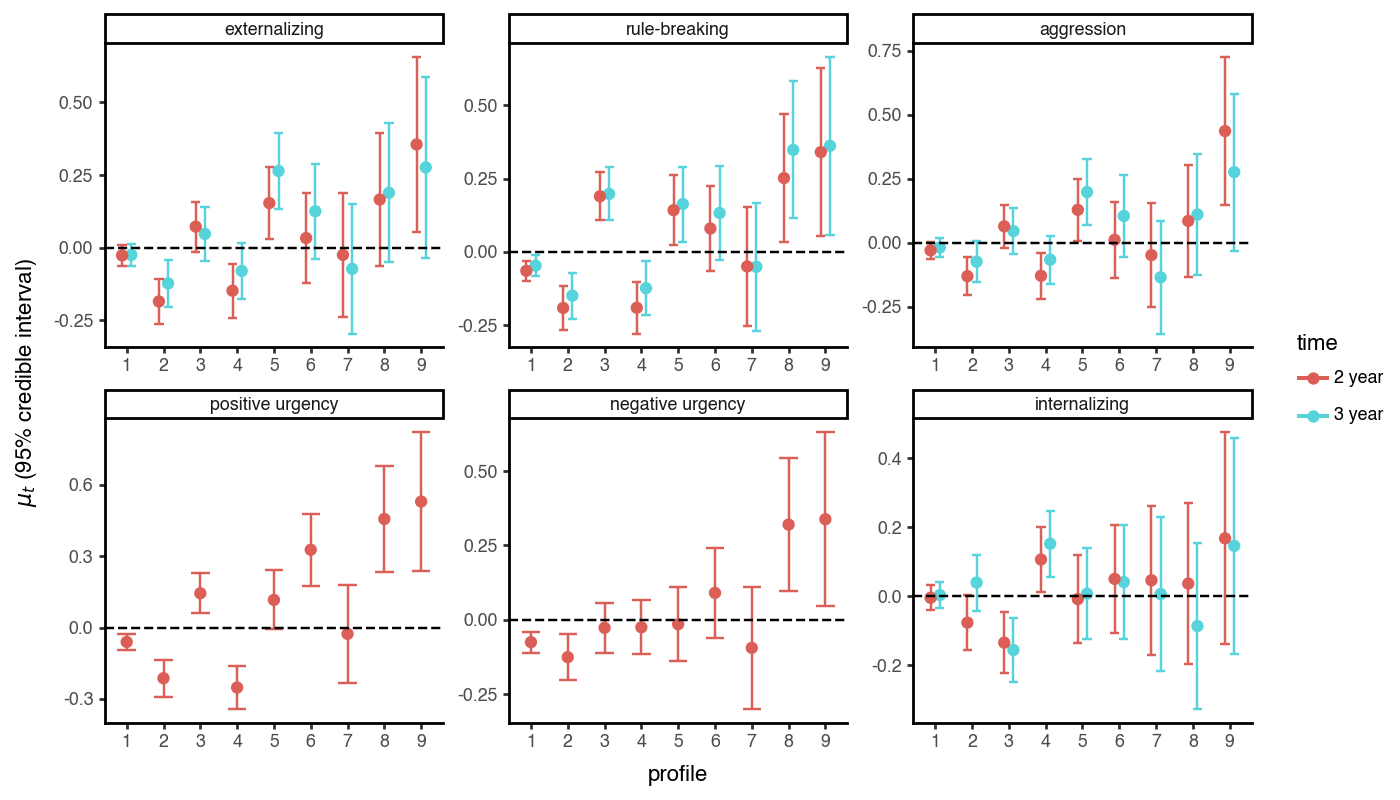

In [27]:
# CREATE COMBINED 2-YEAR AND 3-YEAR OUTCOME PLOT (CONT VARIABLES)
cont_2year['plot_df']['time'] = '2 year'
cont_3year['plot_df']['time'] = '3 year'
combo_cont_plot_df = pd.concat([cont_2year['plot_df'], cont_3year['plot_df']])
vars_to_keep = ['externalizing', 'rule-breaking', 'aggression', 'positive urgency', 'negative urgency', 'internalizing']
combo_cont_plot_df = combo_cont_plot_df.loc[combo_cont_plot_df['variable'].isin(vars_to_keep), :]
combo_cont_plot_df['variable'] = pd.Categorical(combo_cont_plot_df['variable'],
                                                categories = vars_to_keep,
                                                ordered = True)

plot = p9.ggplot(combo_cont_plot_df, p9.aes(color = 'time', x = 'profile', y = 'mu', ymin = 'mu_minus', ymax = 'mu_plus'))
plot += p9.geom_point(position = p9.position_dodge(0.5))
plot += p9.geom_errorbar(position = p9.position_dodge(0.5))
plot += p9.geom_hline(yintercept = 0, linetype = 'dashed')
plot += p9.theme_classic(base_size = 8)
plot += p9.theme(figure_size = [7, 4])
plot += p9.ylab('$\\mu_t$ (95% credible interval)')
plot += p9.facet_wrap('variable', scales = 'free', ncol = 3)
#plot += p9.ggtitle('2 year vs. 3 year follow-up, profile means')
plot.save(plot_path + 'continuous outcomes (combined)', dpi = 300)
plot

/Users/sampaskewitz/miniconda3/envs/abcd/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 14.3 x 7 in image.
/Users/sampaskewitz/miniconda3/envs/abcd/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /Users/sampaskewitz/Dropbox/SamP-Arielle/ABCD Fingerprint/figures for paper/continuous outcomes (combined) poster version


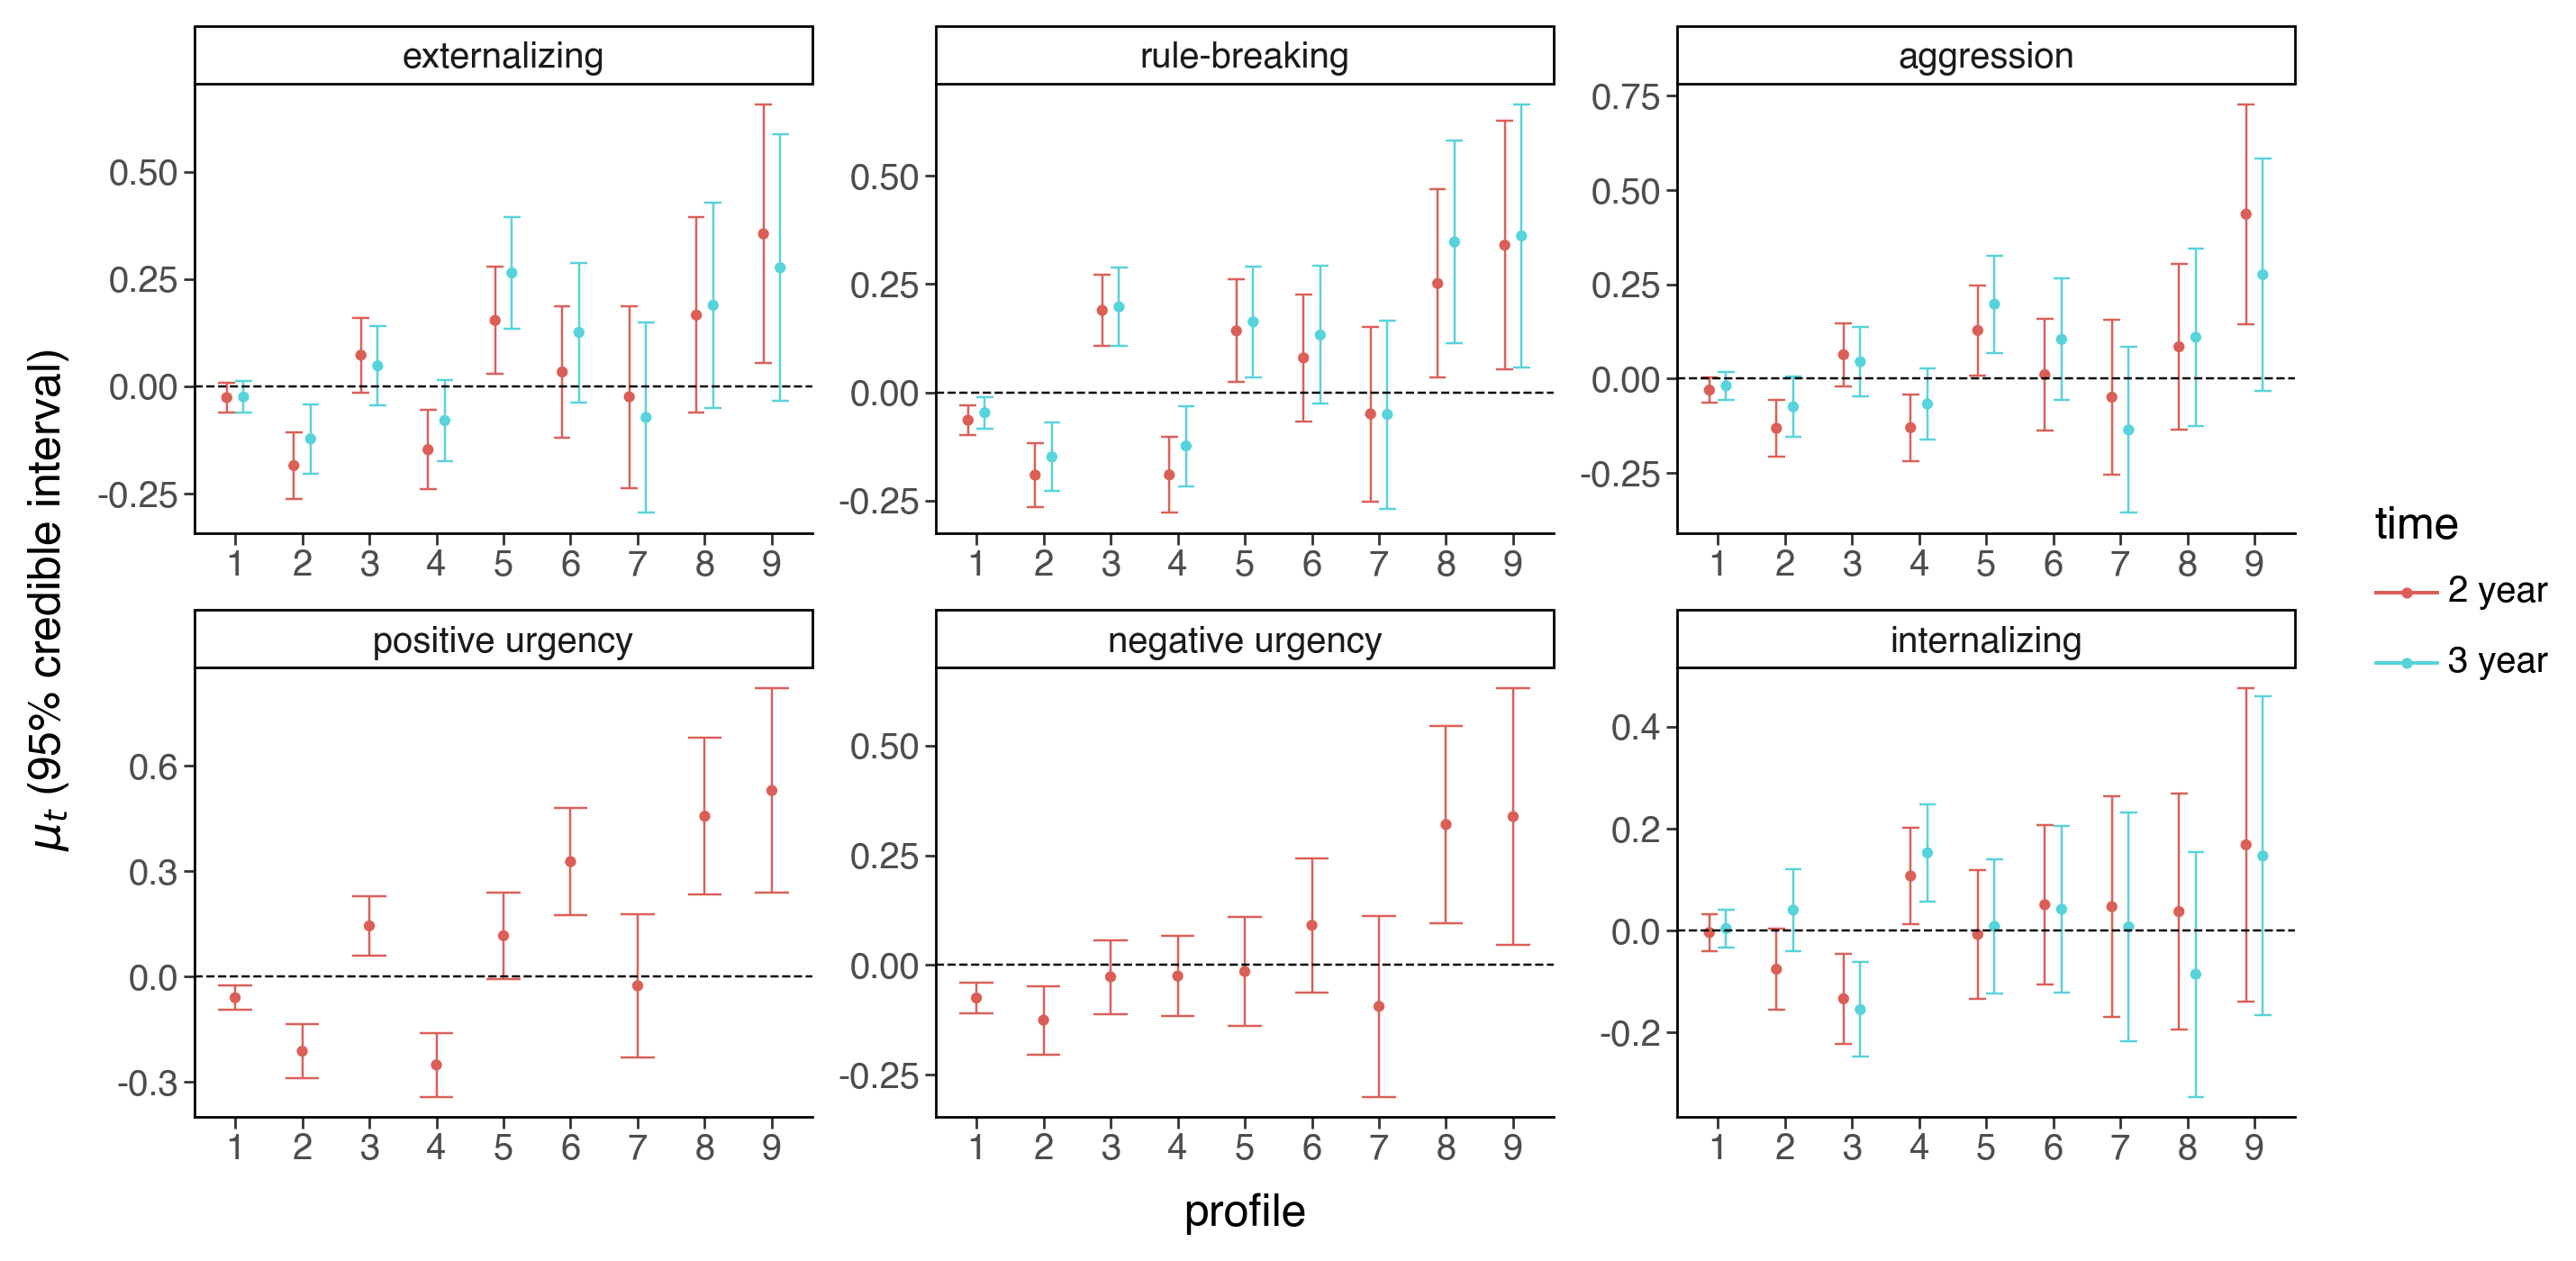

In [28]:
# poster version
plot = p9.ggplot(combo_cont_plot_df, p9.aes(color = 'time', x = 'profile', y = 'mu', ymin = 'mu_minus', ymax = 'mu_plus'))
plot += p9.geom_point(position = p9.position_dodge(0.5))
plot += p9.geom_errorbar(position = p9.position_dodge(0.5))
plot += p9.geom_hline(yintercept = 0, linetype = 'dashed')
plot += p9.theme_classic(base_size = 18)
plot += p9.theme(figure_size = [14.3, 7])
plot += p9.ylab('$\\mu_t$ (95% credible interval)')
plot += p9.facet_wrap('variable', scales = 'free', nrow = 2)
plot.save(plot_path + 'continuous outcomes (combined) poster version', dpi = 300)
plot